## Notebook to explain an individual with different backgrounds


In [1]:
# Development mode: automatic reloading of modules
%load_ext autoreload
%autoreload 2

In [22]:
from model import nhanes_mlp
from deepshap.data import load_nhanes, get_nhanes_feat_names
import xgboost
import shap
import os
import scipy
import sklearn
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

# current working directory
current_directory = os.getcwd()
print("Current directory: ", current_directory)

# print absolute paths
append_path = ("../..")
sys.path.append(append_path)
print("Append directory: ", os.path.abspath(append_path))


# Load data
trainx, trainy, _, _, testx, testy = load_nhanes()
feat_names = get_nhanes_feat_names()

# Load model
model = nhanes_mlp()

Current directory:  /Users/ywu/InSync/2019_Computations/ML-Snippets/DeepSHAP/1_multiple_references/NHANES_background_distribution
Append directory:  /Users/ywu/InSync/2019_Computations/ML-Snippets/DeepSHAP
Epoch 1/50
63/63 [==============================] - 2s 8ms/step - loss: 0.6827 - accuracy: 0.6296 - val_loss: 0.5806 - val_accuracy: 0.6886
Epoch 2/50
63/63 [==============================] - 0s 6ms/step - loss: 0.5860 - accuracy: 0.6930 - val_loss: 0.5022 - val_accuracy: 0.7839
Epoch 3/50
63/63 [==============================] - 0s 5ms/step - loss: 0.5356 - accuracy: 0.7427 - val_loss: 0.4709 - val_accuracy: 0.8011
Epoch 4/50
63/63 [==============================] - 0s 4ms/step - loss: 0.5016 - accuracy: 0.7704 - val_loss: 0.4619 - val_accuracy: 0.8101
Epoch 5/50
63/63 [==============================] - 0s 5ms/step - loss: 0.4895 - accuracy: 0.7845 - val_loss: 0.4490 - val_accuracy: 0.8112
Epoch 6/50
63/63 [==============================] - 0s 5ms/step - loss: 0.4708 - accuracy: 0.7

### Explain a single older male sample


In [23]:
from sklearn.model_selection import train_test_split
from deepshap.data import preprocessed_data

# Get the raw un-standardized data
X, y = preprocessed_data()
pids = np.unique(X.index.values)
train_pids, test_pids = train_test_split(pids, random_state=0)
strain_pids, valid_pids = train_test_split(train_pids, random_state=0)
strain_inds = np.where([p in strain_pids for p in X.index.values])[0]
raw_trainx = X.iloc[strain_inds, :]

In [38]:
print(len(feat_names))

80


sex_isFemale               False
age                           66
physical_activity              4
serum_albumin                3.9
alkaline_phosphatase         NaN
                           ...  
uric_acid_isTestnotdone    False
systolic_blood_pressure    166.0
pulse_pressure              70.0
weight                     86.52
height                     164.7
Name: 85, Length: 80, dtype: object


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


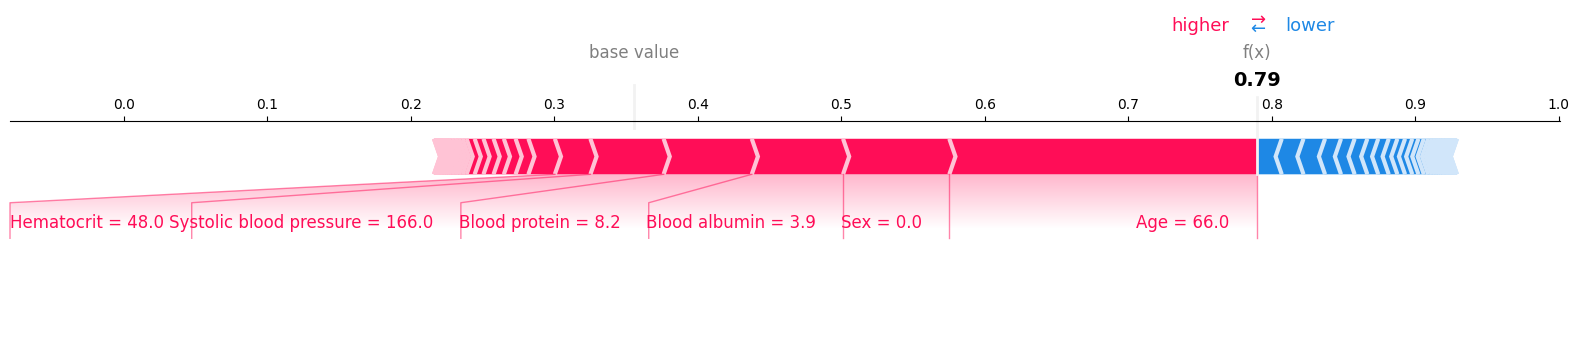

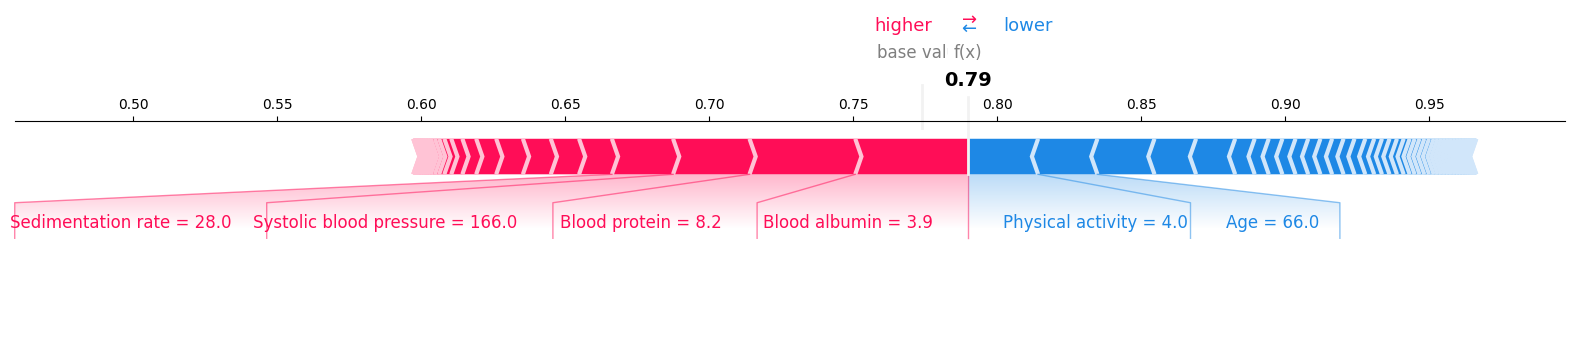

In [51]:
shap.initjs()

# Get older male data set
older_male_inds = (raw_trainx["sex_isFemale"] ==
                   False) & (raw_trainx["age"] > 60)
trainx_older_males = trainx[older_male_inds]
raw_trainx_older_males = raw_trainx[older_male_inds]

# Older male sample to explain
expli_ind = 5
explicand = trainx_older_males[expli_ind:expli_ind+1, :]
explicand_raw = raw_trainx_older_males.iloc[expli_ind]
print(explicand_raw)

# is_save = True
is_save = False

#####################################################
### Explain with background of random individuals ###
#####################################################
np.random.seed(10)
n = trainx_older_males.shape[0]
stepsize = 1000
refe = trainx[np.random.choice(n, stepsize, replace=False)]
expl = shap.DeepExplainer(model, refe)
attr = expl.shap_values(explicand)[0]

# Make and save force plot
if is_save:
    fig = shap.force_plot(expl.expected_value.numpy(),
                          attr,
                          explicand_raw,
                          feat_names,
                          matplotlib=True,
                          )
    fig.savefig("fig/ind{}_randbackground.pdf".format(expli_ind))
else:
    shap.force_plot(expl.expected_value.numpy(),
                    attr,
                    explicand_raw,
                    feat_names,
                    matplotlib=True)

#####################################################
### Explain with background of random older males ###
#####################################################
# Explain with background of random older males
np.random.seed(10)
n = trainx_older_males.shape[0]
stepsize = 1000
inds = np.random.choice(n, stepsize, replace=False)
refe = trainx_older_males[inds]
expl = shap.DeepExplainer(model, refe)
attr = expl.shap_values(explicand)[0]

# Make and save force plot
if is_save:
    fig = shap.force_plot(expl.expected_value.numpy(),
                          attr,
                          explicand_raw,
                          feat_names,
                          matplotlib=True,
                          show=False)
    fig.savefig("fig/ind{}_oldmalebackground.pdf".format(expli_ind))
else:
    shap.force_plot(expl.expected_value.numpy(),
                    attr,
                    explicand_raw,
                    feat_names, matplotlib=True)